In [1]:
import time
import numpy as np
import os
import _pickle as cPickle
import numpy as np
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name as IMAGENET_CLASS_NAMES
import pycuda.autoinit
import pycuda.driver as drv
import numpy
from PIL import Image
import imagehash
import torch 
import torchvision
from matplotlib import pyplot as plt

from pycuda.compiler import SourceModule

PATH = "../data/cifar-10-batches-py/"
IMAGENET_PATH = "../data/Imagenet32_train/"

In [2]:
def load_batch(batchFile):
    f = open(PATH+batchFile, 'rb')
    
    dict_ = cPickle.load(f, encoding='latin1')
    images = dict_['data']
    labels = dict_['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

In [24]:
CIFAR_IMAGES, CIFAR_LABELS = load_batch("data_batch_1")
CIFAR_CLASS_NAMES = load_classes()
CIFAR_IMAGES = CIFAR_IMAGES.reshape(10000,32,32,3)
CIFAR_IMAGES.shape

(10000, 32, 32, 3)

In [25]:
from torchvision import models
import torch.nn as nn

torch.set_default_device('cuda:0') 
device = torch.device('cuda:0')
MODEL_PATH = "../2.NeuralHashing/mainModel.pth"

In [26]:
resnet50 = models.resnet50(pretrained = True) # weights=ResNet50_Weights.DEFAULT
resnet50.fc = torch.nn.Identity()

class Net2(nn.Module):
    def __init__(self, bits):
        super().__init__()
        self.fc1 = nn.Linear(2048, 256)
        self.hash1 = nn.Linear(256, bits)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(bits, 10)

    def forward(self, x):
        x = x.to(torch.float32)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.hash1(x)
        hash_= self.sigmoid(x);
        x = self.fc2(x)
        return x, hash_

In [27]:
net2 = Net2( 64 )
model = nn.Sequential(resnet50, net2)
model.load_state_dict(torch.load(MODEL_PATH))

for param in resnet50.parameters():
    param.requires_grad = False

model = model.eval()

In [40]:
def calculate_signature_model_np(image, hash_size: int) -> np.ndarray:
    img = torch.tensor(image).to(torch.float32)
    img = torch.unsqueeze(img, 0)
    labelA, hashA = model( img )
    return torch.round(hashA).to(torch.int).cpu().detach().numpy().flatten()

In [41]:
from typing import List, Dict, Tuple

class LSH:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):  # shingels
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        idx = 0;
        for image in images:
            signature = calculate_signature_model_np(image.T, self.hash_size)
            self.signatures[idx] = np.packbits(signature.astype(np.uint8))
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates
            

In [57]:
import time

start = time.time()

lsh = LSH(4, 8)
shingels = lsh.compute_hash(CIFAR_IMAGES[0:1000])
pairs = lsh.compute_candidate()
duplicates = lsh.check_candidate(pairs,0.9)

end = time.time()
print( "time: ", end - start )

time:  15.715997219085693


In [60]:
print(len(pairs))
print(duplicates[0])

497548
(246, 555, 1.0)


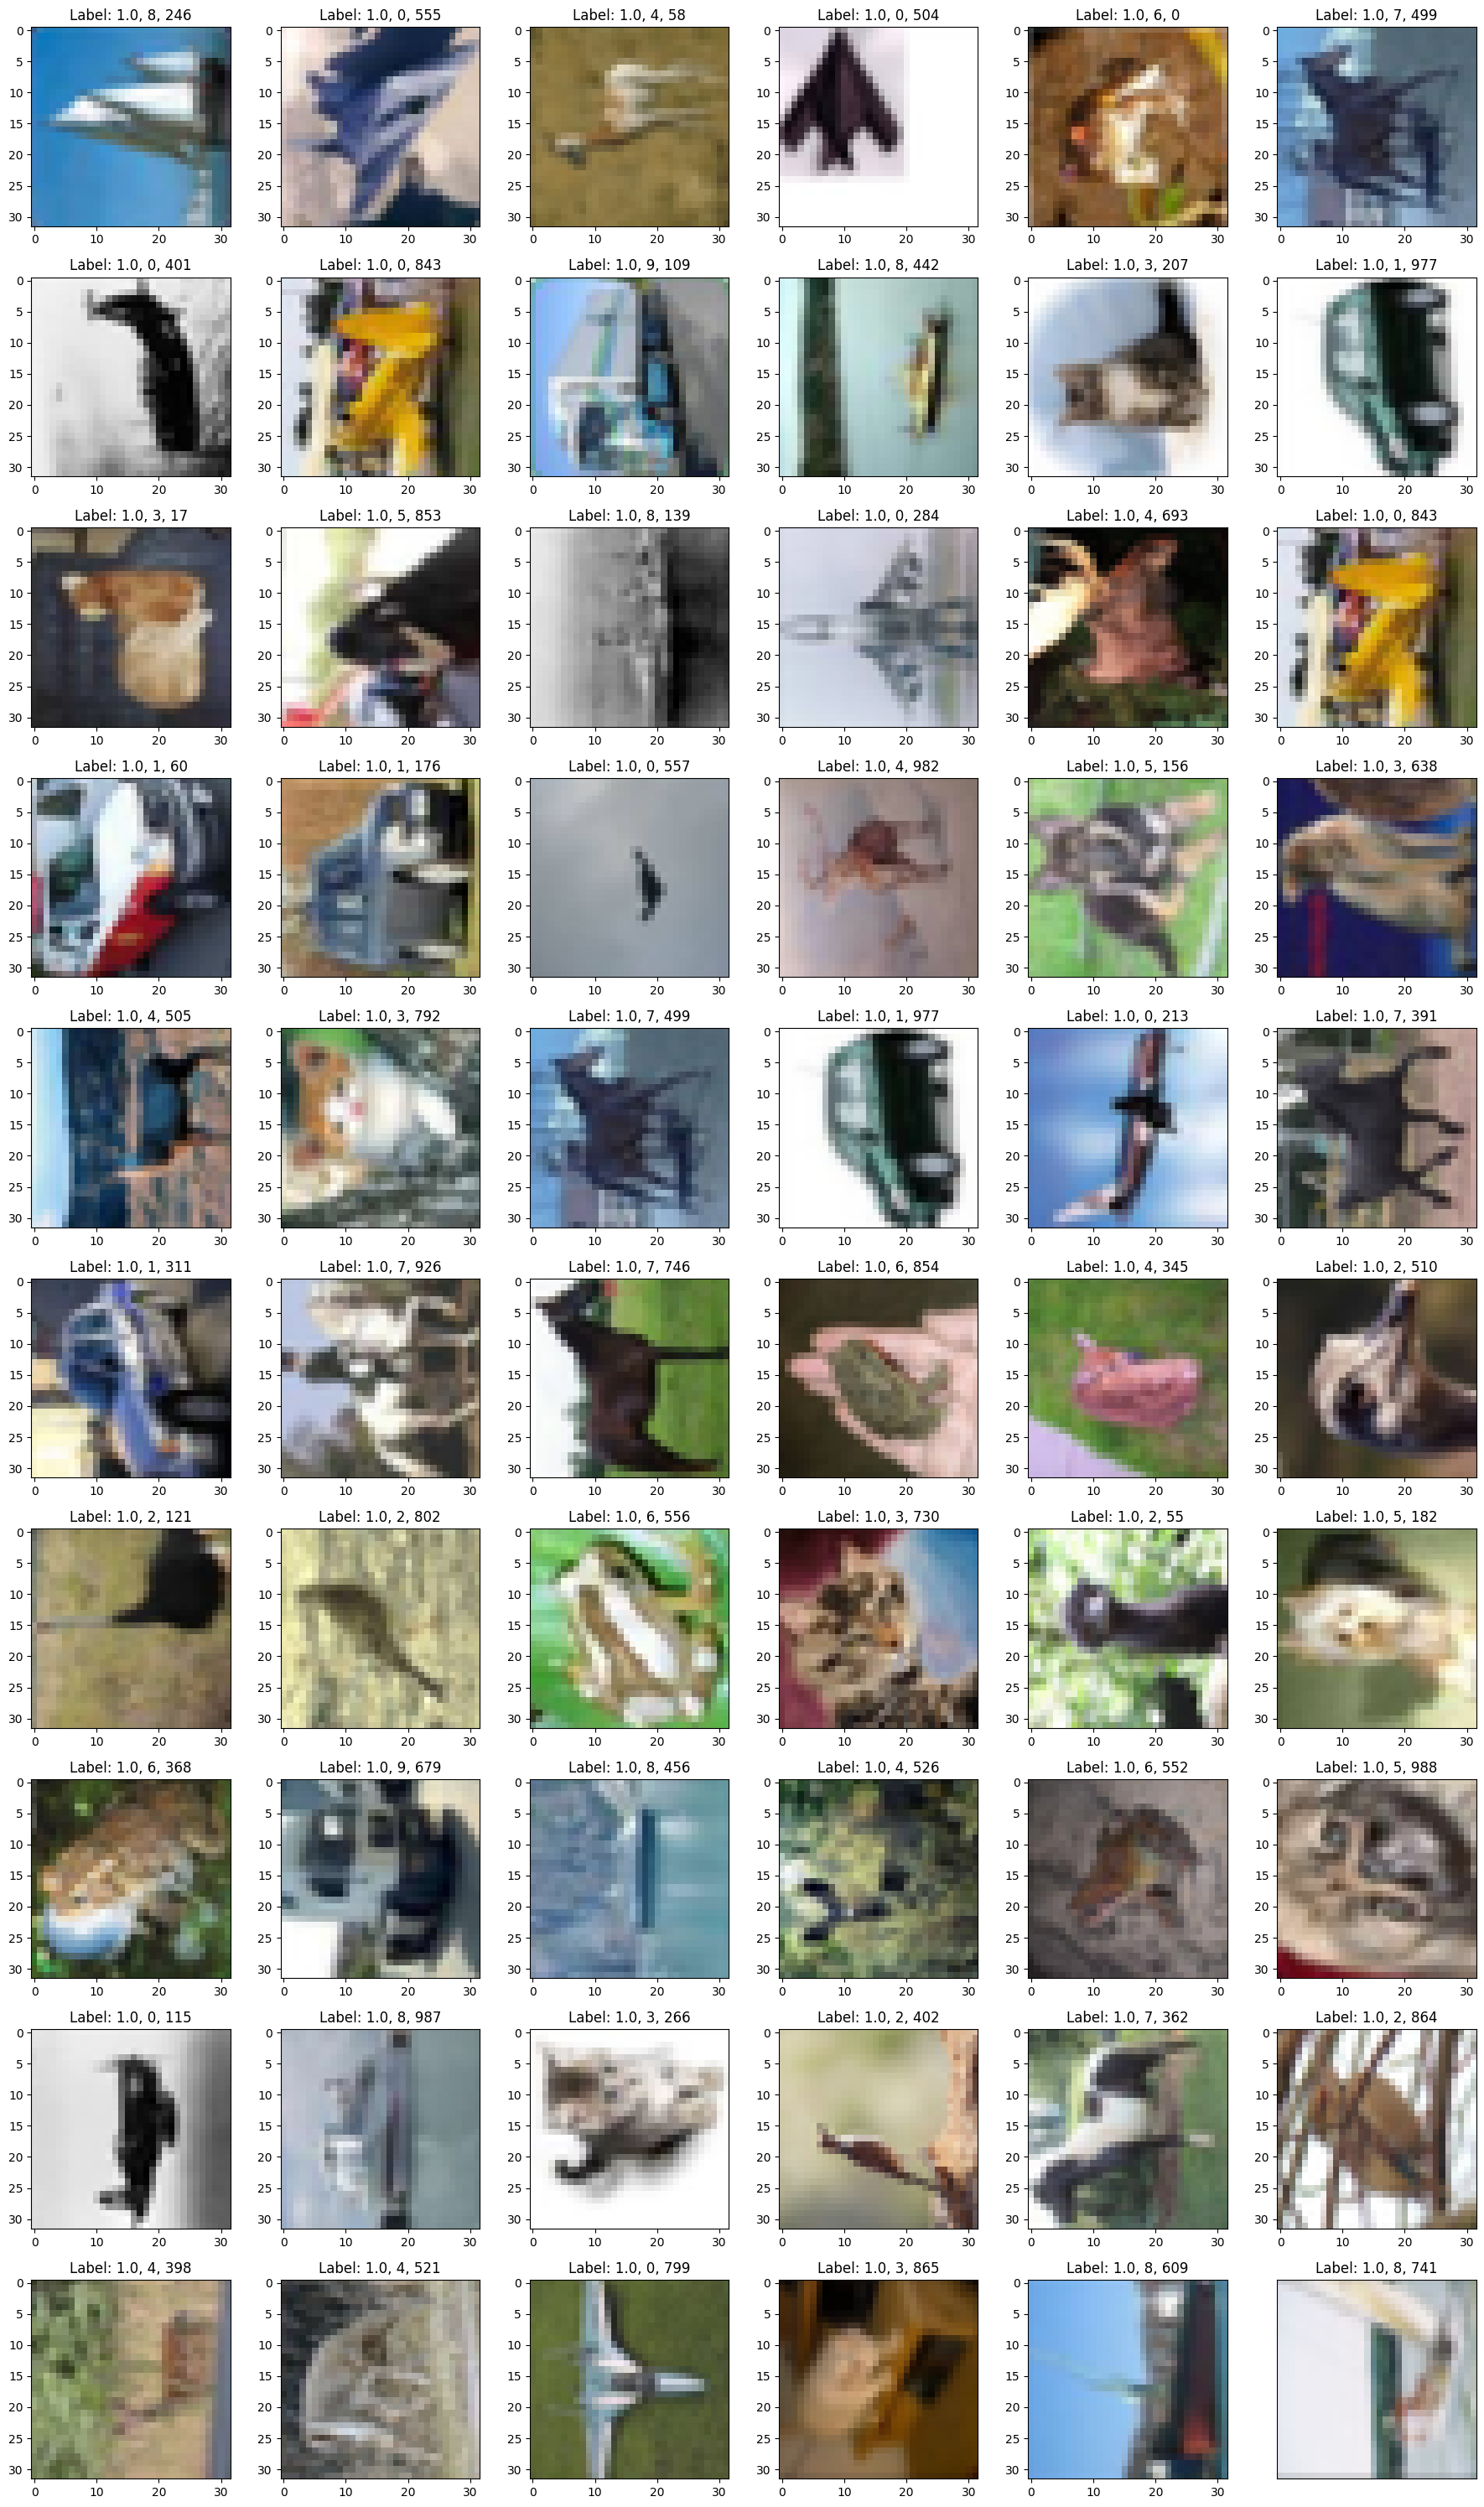

In [59]:
num_row = 10
num_col = 6

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 2):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(CIFAR_IMAGES[duplicates[i//2 + idx_start][0]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {CIFAR_LABELS[duplicates[i//2 + idx_start][0]]}, {duplicates[i//2 + idx_start][0]}""")

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(CIFAR_IMAGES[duplicates[i//2 + idx_start][1]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {CIFAR_LABELS[duplicates[i//2 + idx_start][1]]}, {duplicates[i//2 + idx_start][1]}""")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()